import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [1]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# added to be able to run in Google Colab
import sys
sys.path.append('/content/gdrive/MyDrive/UTRECHT/utils')
sys.path.insert(0,'/content/gdrive/MyDrive/UTRECHT')

import utils

In [3]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
import json
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import random

from skimage.filters import threshold_otsu

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

from utils.flow_functions import *
from utils.dataset import *
from utils.network_arch import *
from utils.trainval_detSegDistTransform import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
1.13.1+cu116


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Feb  4 16:20:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [5]:
#### set project name, save directory for the project

exp_dir = '/content/gdrive/MyDrive/exp/05_Exp3_ContinuousTraining' 

trial_list = ['Trial_01', 'Trial_02','Trial_03','Trial_04','Trial_05']
time_step_list =['T0','T1','T2','Full']
trial = trial_list[2]    # set to the trial number
time_step = time_step_list[1] # set to time step number
t_minus_1_time_step = time_step_list[0] # set to previous time step

save_dir = os.path.join(exp_dir, trial, time_step) 
t_minus_1_save_dir = os.path.join(exp_dir, trial, t_minus_1_time_step)

eval_dir = '/content/gdrive/MyDrive/eval/05_Exp3_ContinuousTraining' 
eval_dir = os.path.join(eval_dir, trial, time_step) 
if not os.path.exists(eval_dir): 
    os.makedirs(eval_dir)

print(time_step)
print(t_minus_1_time_step)
print(eval_dir)

T1
T0
/content/gdrive/MyDrive/eval/05_Exp3_ContinuousTraining/Trial_03/T1


In [6]:
# Here define the path, which is used to save the log and trained model in training process

# cpu or cuda
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:0'
print(device)

freqShow = 50
weight_reg = 2.0    # balances regression loss with segmentation loss. Value chosen based on past investigation.
weight_background = 0.1   # for regression loss only, downweights background pixels to highlight foreground pollen

#model parameters
batch_size = 4
newSize = [800,800] # set to crop size, to tell model what size tensor to expect
total_epoch_num = 80  # total number of epoch in training
base_lr =0.0005        #0.0005      # base learning rate/
scaleList = [0]      # the number of output layer for U-net
#scale = [0,1,2,3]      # the number of output layer for U-net

log_filename = os.path.join(save_dir, 'train.log')

cuda:0


In [7]:
path_to_image = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999'
with open(os.path.join(t_minus_1_save_dir,'dbinfo.pkl'), 'rb') as handle:
    dbinfo_T0 = pickle.load(handle)   

with open(os.path.join(save_dir,'dbinfo.pkl'), 'rb') as handle:
    dbinfo_T1 = pickle.load(handle)     

dbinfo = {}
dbinfo['train_det_list'] = dbinfo_T0['train_det_list'] + dbinfo_T1['train_det_list']
# dbinfo['test_det_list'] = dbinfo_T0['test_det_list'] + dbinfo_T1['test_det_list']
dbinfo['test_det_list'] = dbinfo_T1['test_det_list']
len(dbinfo['train_det_list']), len(dbinfo['test_det_list'])

(480, 60)

In [8]:
set_name='train'
sampleList = dbinfo[set_name+'_det_list']
idx = 300

path_to_image = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999'

current_example= sampleList[idx]
current_image_path= os.path.join(path_to_image, current_example[0], current_example[0] + '_tiles_withAnnot', current_example[1], current_example[2])

all_points = []
all_radii = []
for file in os.listdir(current_image_path):
  if file.endswith('.json'):
      with open(os.path.join(current_image_path, file), "r",encoding="utf-8") as f:
          tmpData = json.load(f)            
          for shape in sorted(tmpData["shapes"], key=lambda x: x["label"]):
              # full_annot.append(shape)
              # label_name = shape["label"]
              points = shape['points']
              
              xy = [tuple(point) for point in points]
              (cx, cy), (px, py) = xy
              d = math.sqrt((cx - px) ** 2 + (cy - py) ** 2)
              all_points.append(xy[0])
              all_radii.append(d)


print(all_points)
print(all_radii)

[(926.4430379746835, 307.3924050632911)]
[62.28311189945589]


/content/gdrive/MyDrive/exp/05_Exp3_ContinuousTraining/Trial_03/T1/pred_masks/49744x_56640y


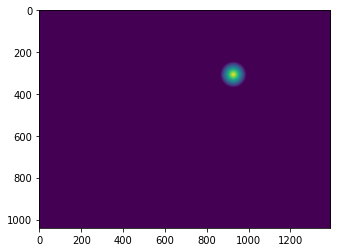

In [9]:
path_to_mask='/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999'
if set_name == 'train' and current_example[1] == 'PAL1999_C6_sample1_slide2':
    current_distTransform_path = os.path.join(save_dir, 'pred_masks', current_example[2])
else:
    current_distTransform_path=os.path.join(path_to_image, current_example[0], current_example[0] + '_masks2', current_example[1],current_example[2])
print(current_distTransform_path)
for file in os.listdir(current_distTransform_path):
  if file.endswith('.png'):
    mask = Image.open(os.path.join(current_distTransform_path, file))
    mask=np.array(mask)
plt.imshow(mask)

(1040, 1392, 27)


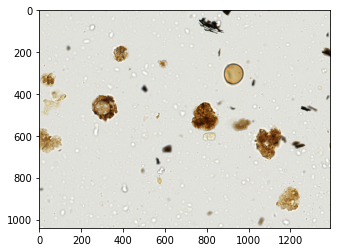

In [10]:
imagestack_array = []
for file in sorted(os.listdir(current_image_path)):
  if file.endswith('.png'):
    slice = Image.open(os.path.join(current_image_path, file))
    imagestack_array.append(np.asarray(slice))
    image = np.block(imagestack_array)
  if image.shape[2] <27:
    pad_val = 27-image.shape[2]
    npad = ((0, 0), (0,0), (0,pad_val))
    image= np.pad(image, pad_width=npad, mode='constant', constant_values=0)

plt.imshow(imagestack_array[4])
print(image.shape)

In [11]:
class PollenDet(Dataset):
    def __init__(self, path_to_image='/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999',
                 path_to_mask='/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999',
                 save_dir = save_dir,
                 dbinfo=dbinfo,
                 size=[1040,1392], 
                 set_name='train'):
        
        self.save_dir = save_dir
        self.path_to_image = path_to_image
        self.path_to_mask = path_to_mask
        self.transform = transform
        self.dbinfo = dbinfo
        if set_name=='val':
            set_name = 'test'
        self.set_name = set_name        
        self.size = size
        self.resizeFactor = size[0]/1000
        
        self.sampleList = self.dbinfo[set_name+'_det_list']

        self.TFNormalize = transforms.Normalize([0.5] * 27, [0.5]*27)
        self.current_set_len = len(self.sampleList)
        
        self.TF2tensor = transforms.ToTensor()
        self.TF2PIL = transforms.ToPILImage()
        # self.TFresize = transforms.Resize((self.size[0],self.size[1]))

        
        self.TFRandomCrop = transforms.RandomCrop(800)
        # self.TFCrop = transforms.Crop(img, top, left, height, width)
        self.TFHFlip = transforms.RandomHorizontalFlip()

    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):        
        current_example= self.sampleList[idx] 

        current_image_path= os.path.join(self.path_to_image, current_example[0], current_example[0] + '_tiles_withAnnot', current_example[1],current_example[2])
        if self.set_name == 'train' and current_example[1] == 'PAL1999_C6_sample1_slide2':
            current_distTransform_path = os.path.join(self.save_dir, 'pred_masks', current_example[2])
        else:
            current_distTransform_path=os.path.join(self.path_to_image, current_example[0], current_example[0] + '_masks2', current_example[1],current_example[2])
        # curPickleName = os.path.join(self.path_to_annot, current_example)

        imagestack_array = []
        for file in sorted(os.listdir(current_image_path)):
          if file.endswith('.png'):
            slice = Image.open(os.path.join(current_image_path, file))
            imagestack_array.append(np.asarray(slice))
        image = np.block(imagestack_array)
        if image.shape[2] <27:
          pad_val = 27-image.shape[2]
          npad = ((0, 0), (0,0), (0,pad_val))
          image= np.pad(image, pad_width=npad, mode='constant', constant_values=0)

        for file in os.listdir(current_distTransform_path):
          if file.endswith('.png'):
            mask = Image.open(os.path.join(current_distTransform_path, file))
            mask=np.array(mask)

        TP_points = []
        TP_radii = []
        for file in os.listdir(current_image_path):
          if file.endswith('full_annot.plk'):
              with open(os.path.join(current_image_path, file), 'rb') as handle:
                  tmpData = pickle.load(handle) 
                  for shape in tmpData:
                      label_name = shape["label"]
                      points = shape['points']
                      xy = [tuple(point) for point in points]
                      (cx, cy), (px, py) = xy
                      d = math.sqrt((cx - px) ** 2 + (cy - py) ** 2)
                      TP_points.append(xy[0])
                      TP_radii.append(d)    
        

        label = np.copy(mask)         # 11/30/21 added
        label[label > 0] = 1          # 11/30/21 added
        
        mask_distanceTransform = mask     #11/18/21 edited
        mask_peaks = label*0.
        mask_radius = label*0.
        mask_voteX = label*0.
        mask_voteY = label*0.
        mask_overlap = label*0.
        
        # for i in range(len(all_points)):
        for i in range(len(TP_points)):
            x, y = TP_points[i]
            x, y = int(x), int(y)
            r = TP_radii[i]
            mask_peaks[y-10:y+10, x-10:x+10] = 1
            mask_radius[y-10:y+10, x-10:x+10] = r

            mask_x, mask_y = np.asarray(range(label.shape[1])).astype(np.float), np.asarray(range(label.shape[0])).astype(np.float)
            mask_x, mask_y = np.meshgrid(mask_x, mask_y)
            mask_x = float(x) - mask_x
            mask_y = float(y) - mask_y

            tmpDistTransform = np.sqrt(mask_x*mask_x + mask_y*mask_y)
            tmpmask_vote = tmpDistTransform <= r
            # label[tmpmask_vote] = 1.0     #11/18/21 commented out
            mask_voteX[tmpmask_vote] = mask_x[tmpmask_vote]
            mask_voteY[tmpmask_vote] = mask_y[tmpmask_vote]
            # mask_distanceTransform[tmpmask_vote] = r-tmpDistTransform[tmpmask_vote]    #11/18/21 commented out
            mask_overlap += tmpmask_vote.astype(np.float)
            
        mask_overlap = mask_overlap>1
        mask_overlap = mask_overlap.astype(np.float32)/100.0/self.resizeFactor 
        mask_voteX = mask_voteX.astype(np.float32)/100.0/self.resizeFactor 
        mask_voteY = mask_voteY.astype(np.float32)/100.0/self.resizeFactor 
        mask_distanceTransform = mask_distanceTransform.astype(np.float32)/100.0/self.resizeFactor  # factor=size[0]/1000
        mask_peaks = mask_peaks.astype(np.float32)/100.0/self.resizeFactor 
        mask_radius = mask_radius.astype(np.float32)/100.0/self.resizeFactor 
        
        image = self.TF2tensor(image)
        label = torch.from_numpy(label).unsqueeze(0) # self.TF2tensor(label)
        mask_overlap = torch.from_numpy(mask_overlap).unsqueeze(0) # self.TF2tensor(mask_overlap)
        mask_voteX = torch.from_numpy(mask_voteX).unsqueeze(0) # self.TF2tensor(mask_voteX)
        mask_voteY = torch.from_numpy(mask_voteY).unsqueeze(0) # self.TF2tensor(mask_voteY)
        mask_distanceTransform = torch.from_numpy(mask_distanceTransform).unsqueeze(0) # self.TF2tensor(mask_distanceTransform)
        mask_peaks = torch.from_numpy(mask_peaks).unsqueeze(0) # self.TF2tensor(mask_peaks)
        mask_radius = torch.from_numpy(mask_radius).unsqueeze(0) # self.TF2tensor(mask_radius)

        image = image.unsqueeze(0)
        label = label.unsqueeze(0)        
        mask_distanceTransform = mask_distanceTransform.unsqueeze(0)
        mask_overlap = mask_overlap.unsqueeze(0)
        mask_voteX = mask_voteX.unsqueeze(0)
        mask_voteY = mask_voteY.unsqueeze(0)        
        mask_peaks = mask_peaks.unsqueeze(0)
        mask_radius = mask_radius.unsqueeze(0)        

        image_label = torch.cat([image, label,mask_distanceTransform,mask_overlap,mask_voteX,mask_voteY,mask_peaks, mask_radius], dim=1) #new 10/21/21 stack label with image for crop
        image_label = self.TFRandomCrop(image_label) #new 10/21/21
        image_label = self.TFHFlip(image_label)
        image = torch.narrow(image_label, 1, 0, image_label.shape[1]-7) #new 10/27/21  re-slice tensor into image and label
        label=torch.narrow(image_label, 1, image_label.shape[1]-7, 1) #new 10/27/21  re-slice tensor into image and label
        mask_distanceTransform=torch.narrow(image_label, 1, image_label.shape[1]-6, 1)
        mask_overlap=torch.narrow(image_label, 1, image_label.shape[1]-5, 1)
        mask_voteX=torch.narrow(image_label, 1, image_label.shape[1]-4, 1)
        mask_voteY=torch.narrow(image_label, 1, image_label.shape[1]-3, 1)
        mask_peaks=torch.narrow(image_label, 1, image_label.shape[1]-2, 1)
        mask_radius=torch.narrow(image_label, 1, image_label.shape[1]-1, 1)

        image = image.squeeze(0)
        label = label.squeeze(0)
        image_label = image_label.squeeze(0)
        mask_distanceTransform = mask_distanceTransform.squeeze(0)
        mask_overlap = mask_overlap.squeeze(0)
        mask_voteX = mask_voteX.squeeze(0)
        mask_voteY = mask_voteY.squeeze(0)
        mask_peaks = mask_peaks.squeeze(0)
        mask_radius = mask_radius.squeeze(0)
        image = self.TFNormalize(image)

        return image, label, mask_distanceTransform, mask_overlap, mask_voteX, mask_voteY, mask_peaks, mask_radius # current_example, idx

In [12]:
# batch_size = 200

det_datasets = {set_name: PollenDet(path_to_image=path_to_image,
                                    # path_to_annot=path_to_annotCombo,
                                    dbinfo=dbinfo,
                                    size=newSize, 
                                    set_name=set_name)
                for set_name in ['train', 'test']}


dataloaders = {set_name: DataLoader(det_datasets[set_name],                                    
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=8) # num_work can be set to batch_size. Increasing # workers may speed up data loading 
               for set_name in ['train', 'test']}

print(len(det_datasets['train']), len(det_datasets['test']))

480 60


In [13]:
#this is the return line

data_sampler = iter(dataloaders['train'])
# print(sample)

In [14]:
data = next(data_sampler)

In [15]:
image=data[0]
# mask_distanceTransform=sample[1]
label=data[1]
mask_distanceTransform=data[2]
mask_peaks=data[6]
# current_example = data[8]
# idx = data[9]

# print(current_example)
# print(idx)

# for idx in range(len(sample)):
#   print(sample[idx].shape)

Text(0.5, 1.0, 'image slice')

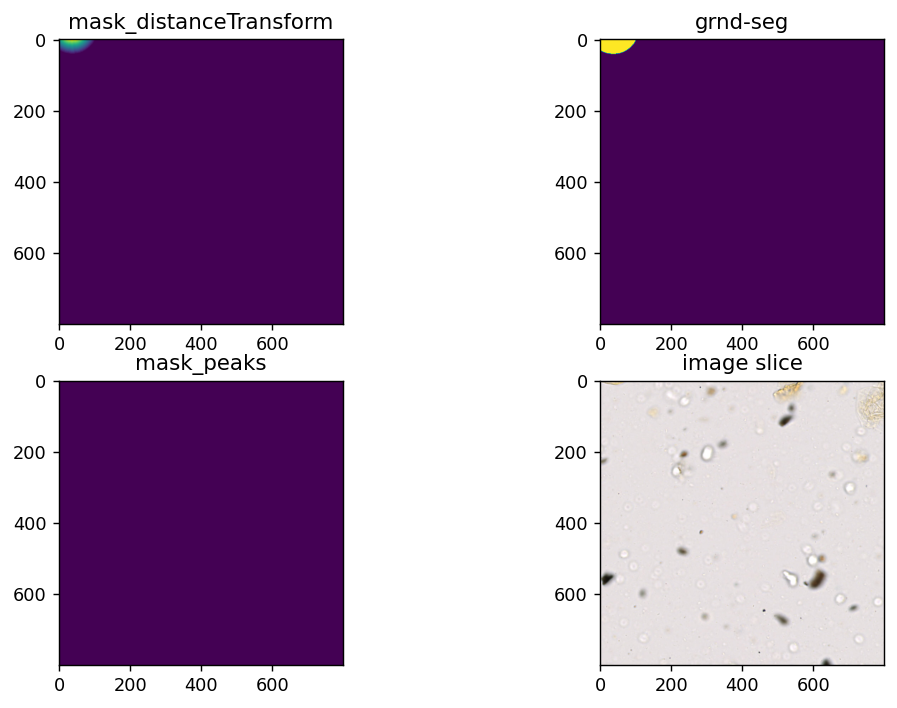

In [16]:
idx = 2

numSample2Show = 1
figWinNumHeight, figWinNumWidth = 3, 2
plt.figure(figsize=(10, 10), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = mask_distanceTransform[idx].squeeze().cpu().detach().numpy()  #.transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('mask_distanceTransform')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = label[idx].squeeze().cpu().detach().numpy()  #.transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('grnd-seg')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = mask_peaks[idx].squeeze().cpu().detach().numpy()  #.transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('mask_peaks')

i=[0,3,6,9,12,15,18,21,24]
j=[3,6,9,12,15,18,21,24,27]
idx2=3
image_slice = image[:, int(i[idx2]):int(j[idx2]),: ,:]

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = image_slice[idx].squeeze().cpu().detach().numpy().transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('image slice')


In [17]:
################## init model ###################
initModel = PollenDet_SegDistTransform(34, scaleList=scaleList, pretrained=False)
initModel.encoder.encoder.conv1 = nn.Conv2d(27, 64, (7, 7), (2, 2), (3, 3), bias=False) #change dimensions of the first layer in the encoder
initModel = initModel.to(device);

# # print(initModel.encoder.encoder)

In [18]:
# loss for regression with masking
class MaskWeightedL1(nn.Module):
    def __init__(self, wBG=0.5, wFactor=1):
        super(MaskWeightedL1, self).__init__()        
        self.wBG = wBG
        self.wFactor = wFactor 
        
    def forward(self, inputs, target, segMask, overlapMask): 
        N, C, H, W = inputs.shape    #if mask only has 1 channel, C=1
        output = inputs - target
        totalNum = H * W * N
        output = torch.abs(output)
        output = torch.mean(output, 1, keepdim=True)
                
        output = output * (segMask + self.wBG) * (1-overlapMask)
        
        lossValue = output.sum() / totalNum
        return lossValue*self.wFactor

In [19]:
# loss for (binary) segmentation
weight = torch.ones(2)
weight[0] = 0.5
weight = weight.to(device)
#lossFunc_seg = nn.CrossEntropyLoss(weight=weight, reduction='elementwise_mean')
lossFunc_seg = nn.BCELoss(reduction='mean')

# loss for regression with masking
lossFunc_reg = MaskWeightedL1(wBG=weight_background, wFactor=weight_reg)

In [20]:
optimizer = optim.Adam([{'params': initModel.encoder.parameters()},
                        {'params': initModel.decoder.parameters()}], 
                       lr=base_lr, weight_decay=0.0005) 

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=int(total_epoch_num/4), gamma=0.4)

# if training for the first time

In [21]:
# ################# start training ###################
# fn = open(log_filename,'w')
# fn.write(log_filename+'\t'+device+'\n\n')
# #fn.write(path.basename(__file__)+'\n\n')
# fn.close()
# file_to_note_bestModel = os.path.join(save_dir,'note_bestModel.log')
# fn = open(file_to_note_bestModel, 'w')
# fn.write('Record of best models on the way.\n')
# fn.close()

# Load the parameters from the T-minus-1 model

In [22]:
# if model freezes during training, load the last checkpoint. 

checkpoint = torch.load(path.join(t_minus_1_save_dir, 'bestValModel.pt'))
initModel.load_state_dict(checkpoint['model'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# epoch = checkpoint['epoch'] +1
epoch = 0
# best_loss = 0.139327 # use best loss of previous training
initModel.to(device) 
initModel.train(); # must be used when loading a checkpoint

In [ ]:
# print(epoch)
# print(best_loss)

In [23]:
################## start training ###################
# make sure to change log filename, file to note best model if you don't want the previous one overwritten

fn = open(log_filename,'w')
fn.write(log_filename+'\t'+device+'\n\n')
#fn.write(path.basename(__file__)+'\n\n')
fn.close()
file_to_note_bestModel = os.path.join(save_dir,'note_bestModel.log')
fn = open(file_to_note_bestModel, 'w')
fn.write('Record of best models on the way.\n')
fn.close()

# train model

In [24]:
model_ft = train_model(initModel, dataloaders, 
                       lossFunc_seg, lossFunc_reg, 
                       optimizer, exp_lr_scheduler,
          
                       scaleList=scaleList, 
                       start_epoch=0,
                       num_epochs=total_epoch_num, 
                       work_dir=save_dir, 
                       device=device,
                       freqShow=freqShow)


Epoch 1/80
----------
train
	50/120 seg:0.057, reg:0.017
2m 57s
	100/120 seg:0.050, reg:0.014
2m 51s
	loss: 0.063645
test
	loss: 0.050223

Epoch 2/80
----------
train
	50/120 seg:0.041, reg:0.009
0m 41s
	100/120 seg:0.046, reg:0.011
0m 39s
	loss: 0.058754
test
	loss: 0.054273

Epoch 3/80
----------
train
	50/120 seg:0.050, reg:0.014
0m 40s
	100/120 seg:0.048, reg:0.013
0m 39s
	loss: 0.065403
test
	loss: 0.067015

Epoch 4/80
----------
train
	50/120 seg:0.052, reg:0.013
0m 40s
	100/120 seg:0.093, reg:0.020
0m 39s
	loss: 0.112475
test
	loss: 0.142876

Epoch 5/80
----------
train
	50/120 seg:0.061, reg:0.022
0m 39s
	100/120 seg:0.058, reg:0.019
0m 39s
	loss: 0.077439
test
	loss: 0.075381

Epoch 6/80
----------
train
	50/120 seg:0.058, reg:0.015
0m 41s
	100/120 seg:0.052, reg:0.014
0m 39s
	loss: 0.065974
test
	loss: 0.080749

Epoch 7/80
----------
train
	50/120 seg:0.054, reg:0.016
0m 40s
	100/120 seg:0.052, reg:0.016
0m 39s
	loss: 0.066367
test
	loss: 0.061783

Epoch 8/80
----------
trai

KeyboardInterrupt: ignored

In [ ]:
print(set_name)

train
